In [7]:
import sys
sys.path.append("..")  # Adds the parent directory to the system pat

from script.sahr_fin_flutter import calculate_flutter_velocity as sahr_cfv , list_of_flutter_velocities
from script.howard_fin_flutter import calculate_flutter_velocity as howard_cfv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Manual

In [17]:
altitude = 3000  # in feet
shear_modulus = 380000  # in psi
thickness = 0.125  # in inches
root_chord = 9.75  # in inches
tip_chord = 3.75  # in inches
semispan = 4.75  # in inches
sea_level_sound = 1100  # in ft/s
sea_level_pressure = 14.7  # in psi
atmospheric_scale_height = 26500  # ft
thickness_increments = 0.01
maximum_thickness = 0.2
minimum_thickness = 0

# Howard Flutter Velocity

In [9]:
howard_cfv(altitude, shear_modulus, thickness, root_chord, tip_chord, semispan)

788.576441499794

# Sahr Flutter Velocity

In [12]:
sahr_cfv(sea_level_sound, altitude, atmospheric_scale_height, shear_modulus, sea_level_pressure, thickness, root_chord, tip_chord, semispan)

TypeError: calculate_flutter_velocity() missing 1 required positional argument: 'semispan'

In [21]:
lofv=list_of_flutter_velocities(0, maximum_thickness, thickness_increments,sea_level_sound, altitude, atmospheric_scale_height, shear_modulus, sea_level_pressure, root_chord, tip_chord, semispan)

In [19]:
# Create array of thickness values
thicknesses = np.arange(
    minimum_thickness, maximum_thickness + thickness_increments, thickness_increments)

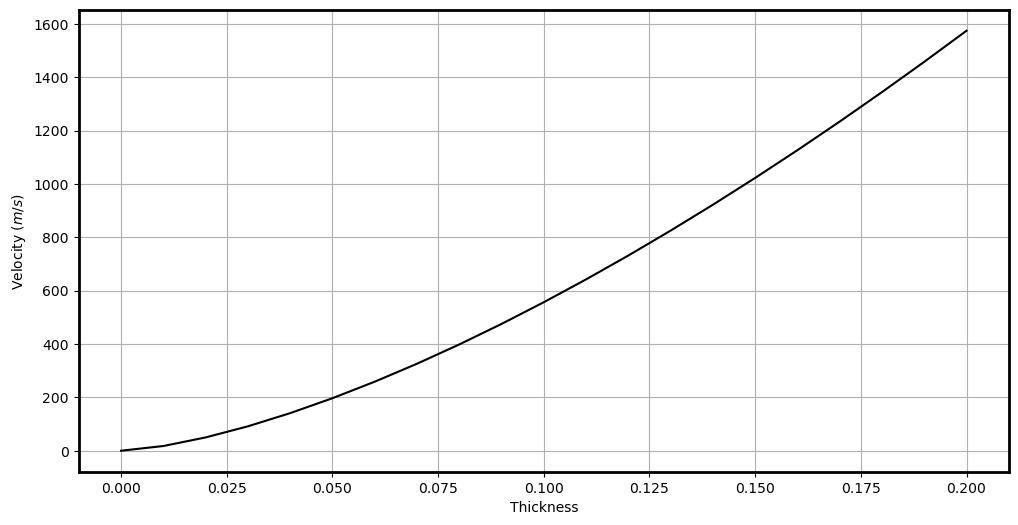

In [22]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel(r"Thickness")
ax1.set_ylabel(r"Velocity ($m/s$)")
ax1.grid(True)
ax1.plot(thicknesses,
         lofv, color='k', label="Flutter")
# ax1.set_ylim(min_drag_rounded, max_drag_rounded)
# ax1.set_xlim(0, max_mach)

# Change spine properties to make the border darker and thicker
for spine in ax1.spines.values():
    spine.set_edgecolor('black')  # Change color to black or any other color
    # Change the thickness. Adjust the value as needed.
    spine.set_linewidth(2)

# ax1.set_yticks(np.arange(0, max_drag+0.1, 0.05))

# Plot event markers
# self.plot_event_markers_mach(ax1)

plt.show()